# Introduction

This notebook presents a simple Generative Adversarial Network (GAN) and more advanced Deep Convolutional GAN. Both are applied MNIST dataset.

We will create three sub-graphs for GAN network as follows:

* **Generator**: *noise -> MNIST images*, contains set of **Generator Weights**, weights are trained in Gan Model, so it doesn't need it's own optimizer
* **Discriminator**: *MNIST images -> fake/real*, contains set of **Discriminator Weights**, trained like usual Keras model
* **Gan Model**: noise -> fake/real, all weights are shared from generator/discriminator above, discriminator weights are set as non-trainable

**Contents**

* [MNIST Dataset](#MNIST-Dataset)
* [Keras GAN](#Keras-GAN)
* [Keras DCGAN](#Keras-DCGAN)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# MNIST Dataset

Load MNIST Dataset from Keras API. We only need train images, ignore labels and validation set.

In [3]:
(x_train_raw, _), (_, _) = tf.keras.datasets.mnist.load_data()

Convert to -1..1 range to mach tanh output from generator

In [4]:
x_train = (x_train_raw-127.5) / 127.5
x_train = x_train.reshape([len(x_train), -1])
print('x_train.shape:', x_train.shape)
print('x_train.min():', x_train.min())
print('x_train.max():', x_train.max())
print('x_train:\n', x_train)

x_train.shape: (60000, 784)
x_train.min(): -1.0
x_train.max(): 1.0
x_train:
 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


# Keras GAN

**Generator**

* converts *noise* input into *MNIST-like* image
* there is no name to compile model, we never optimize generator directly
* I don't think this is an efficient implementation (although very common on the internet) - alternative would be to feed noise directly to gan_model and remove *generator.predict()* call in the train loop.

In [5]:
from tensorflow.keras.layers import InputLayer, Dense                # InputLayer for pretier names in TensorBoard

generator = tf.keras.Sequential(name='Generator')
generator.add(InputLayer(input_shape=(100,), name='GenInput'))       # random noise input
generator.add(Dense(units=128, activation='elu', name='GenHidden'))  # one hidden layer
generator.add(Dense(784, activation='tanh', name='GenOutput'))       # MNIST-like output
# generator.compile(...)                                             # no need
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GenHidden (Dense)            (None, 128)               12928     
_________________________________________________________________
GenOutput (Dense)            (None, 784)               101136    
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


<img src="assets/gan_mlp_generator.png"/>

Optional: see graph created so far in TensorBoard

In [6]:
# writer = tf.summary.FileWriter(logdir='tf_log', graph=tf.get_default_graph())
# writer.flush()

**Discriminator**

* input is *MNIST-like* image, output is *fake/true label*

In [7]:
discriminator = tf.keras.Sequential(name='Discriminator')
discriminator.add(InputLayer(input_shape=(784,), name='DiscInput'))
discriminator.add(Dense(units=128, activation='elu', input_dim=784, name='DiscHidden'))
discriminator.add(Dense(units=1, activation='sigmoid', name='DiscOut'))
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
#discriminator.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002), loss='binary_crossentropy')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DiscHidden (Dense)           (None, 128)               100480    
_________________________________________________________________
DiscOut (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


<img src="assets/gan_mlp_discriminator.png"/>

Optional: see graph created so far in TensorBoard - this should produce two independent sub-graphs, one for generator and one for discriminator

In [8]:
# writer = tf.summary.FileWriter(logdir='tf_log', graph=tf.get_default_graph())
# writer.flush()

**GAN Model**

* we need to set discriminator part as non-trainable before calling compile() - this doesn't affect previously created discriminator
* changing discriminator trainable flag after compile() call has no effect on weights being trainable or not
* note that even though this creates new sub-graph, all weights are shared from generator and discriminator above

In [9]:
discriminator.trainable = False                                  # must make non-trainable before compiling gan_model
gan_model = tf.keras.Sequential(name='GAN')                      # (this doesn't affect anything we done earlier)a
gan_model.add(InputLayer(input_shape=(100,), name='GANInput'))
gan_model.add(generator)
gan_model.add(discriminator)
gan_model.compile(optimizer='adam', loss='binary_crossentropy')
#gan_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002), loss='binary_crossentropy')
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 784)               114064    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 114,064
Non-trainable params: 100,609
_________________________________________________________________


<img src="assets/gan_mlp_gan_model.png"/>

Optional: see graph created so far in TensorBoard - because weights are shared this will create somewhat messy rendering of three sub-graphs

**Train GAN**

In [10]:
n_batch = 200
n_epochs = 20

In [11]:
losses = {'gen':[], 'disc':[]}
indices = np.array(range(len(x_train)))

for e in range(n_epochs):
    np.random.shuffle(indices)
    for i in range(0, len(x_train), n_batch):
        
        # Generate fake images
        noise = np.random.normal(size=[n_batch, 100])             # shape (n_batch, n_rand)
        x_fake = generator.predict(noise, batch_size=n_batch)     # shape (n_batch, n_data)

        # Pick next batch of real images
        i_batch = indices[i:i+n_batch]
        x_real = x_train[i_batch]

        # Join real and fake into one batch
        x_all = np.concatenate([x_real, x_fake])
        y_all = np.concatenate([.9 * np.ones([n_batch,1]),        # use .9 instead 1 as discriminator target
                                np.zeros([n_batch,1])])           # this is called 'smoothing' and improves learning

        # Train discriminator
        discriminator.trainable = True                            # get rid of warning messages (doesn't affect training)
        dloss = discriminator.train_on_batch(x_all, y_all)        # this trains only discriminator, doesn't touch gen.
        
        noise = np.random.normal(size=[n_batch, 100])
        y_fake = np.ones([n_batch, 1])
        discriminator.trainable = False                           # get rid of warning messages 
        gloss = gan_model.train_on_batch(noise, y_fake)
        
        losses['disc'].append(dloss)
        losses['gen'].append(gloss)
        
    print(f'epoch: {e:3}     gloss: {gloss:4.2f}     dloss: {dloss:4.2f}')

epoch:   0     gloss: 1.60     dloss: 0.29
epoch:   1     gloss: 2.86     dloss: 0.21
epoch:   2     gloss: 3.02     dloss: 0.24
epoch:   3     gloss: 3.63     dloss: 0.29
epoch:   4     gloss: 3.38     dloss: 0.31
epoch:   5     gloss: 3.58     dloss: 0.30
epoch:   6     gloss: 3.31     dloss: 0.43
epoch:   7     gloss: 3.46     dloss: 0.24
epoch:   8     gloss: 2.39     dloss: 0.42
epoch:   9     gloss: 2.30     dloss: 0.41
epoch:  10     gloss: 1.69     dloss: 0.50
epoch:  11     gloss: 3.09     dloss: 0.38
epoch:  12     gloss: 2.43     dloss: 0.40
epoch:  13     gloss: 2.43     dloss: 0.39
epoch:  14     gloss: 2.35     dloss: 0.66
epoch:  15     gloss: 2.16     dloss: 0.83
epoch:  16     gloss: 2.33     dloss: 0.49
epoch:  17     gloss: 2.42     dloss: 0.48
epoch:  18     gloss: 2.78     dloss: 0.48
epoch:  19     gloss: 1.80     dloss: 0.59


Plot losses during training

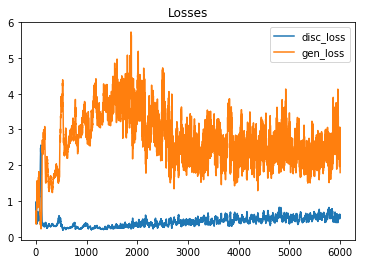

In [12]:
plt.plot(losses['disc'], label='disc_loss')
plt.plot(losses['gen'], label='gen_loss')
plt.title('Losses')
plt.legend();

Helper to show bunch of MNIST-like images

In [20]:
def show_images(x):
    fig, axes = plt.subplots(nrows=1, ncols=len(x), figsize=[20,4])
    for i, ax in enumerate(axes):
        ax.imshow(x[i].reshape([28,28]), cmap='gray', vmin=-1, vmax=1)
        ax.axis('off')

Show some real images

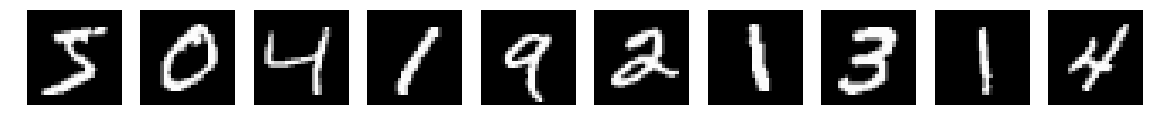

In [21]:
real_imgs = x_train[0:10]
show_images(real_imgs)

Show some fakes

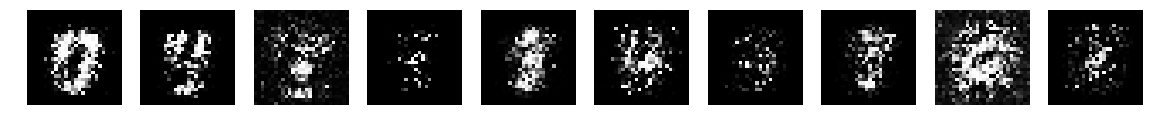

In [22]:
noise = np.random.normal(size=[10, 100])
fake_imgs = generator.predict(x=noise, batch_size=10)
show_images(fake_imgs)

**Generate Graphs**

This was used to generate graphs in this post

In [23]:
# tf.keras.utils.plot_model(generator, to_file='assets/gan_mlp_generator.png', show_shapes=True)
# tf.keras.utils.plot_model(discriminator, to_file='assets/gan_mlp_discriminator.png', show_shapes=True)
# tf.keras.utils.plot_model(model, to_file='assets/gan_mlp_gan_model.png', show_shapes=True)